In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
from deepq import Board, visualize, SinglePredictionQPlayer, MultiPredictionQPlayer,GreedyPlayer, RandomPlayer, MonteCarloPlayer
from scipy.stats import pearsonr
from tqdm.auto import tqdm   


# Applying Double-Q Learning to Connect-4

## Motivation
Reinforcement learning can solve a variety of different complex decision-making problems across a wide variety of domains. One of the more popular reinforcement learning algorithms, Q-learning, can learn optimal policies even in uncertain environments. However, traditional tabular-based Q learning has trouble dealing with problems with a large state space such as Connect-4 which has $4.5 \cdot 10^{12}$ possible states. Due to this limitation, this paper will focus on Deep Q-Learning, specifically the Double-Q variant as the Double-Q variant of Deep-Q learning can mitigate positive bias when estimating the Q value for the next reachable state. We aim to further the understanding of Double-Q learning in a complex state space and determine if it can find an optimal policy for the board game Connect-4.

In this paper, we will focus primarily on the board game Connect-4. Connect-4 is a two-player game played on a vertical 6x7 board. Players take turns placing a token of differing colors to form a horizontal, vertical, or diagonal line of 4 pieces. Players are only able to drop pieces down from a column such that the piece will land in the lowest unoccupied space in said column. Connect-4 is a solved game using minimax search and it has been found that player 1 can guarantee a win if they place the first piece in the center column. We are interested in seeing if a model-free reinforcement learning technique can learn a complex game like Connect-4 as it is desirable to be able to learn a policy with a model-free reinforcement learning algorithm in a complex state space such as connect-4.

The primary objective of this research is to investigate the effectiveness of Double-Q learning in representing a complex state and action space game. We will look at different network architectures, different ways of feeding actions and states to the networks, and different training opponents to see how these affect the ability of the agent to learn the optimal policy. We are interested in learning about the best ways of implementing Q learning in a complex state space. To achieve this, we will train 8 models each with a slightly different configuration. The first question we aim to answer is whether or not the playing power of the opponent helps the Q-learning algorithm play better or converge faster. To test this, we will train agents against a pure random player, and against themselves with the hypothesis that agents trained against themselves will be able to beat harder opponents more consistently while a q player trained against a random opponent will most likely converge faster, but to a less optimal solution. We also want to see if different network architectures can better represent the state space for the agent to play in. We will construct agents that are using a convolutional state encoder layer, and agents that are more of the style of D2RL where they have residual connections from the state input and the hidden layers, but no convolutional encoder. We believe that the agents with a convolutional encoder layer will be able to beat more powerful opponents as the win conditions of Connect-4 can be captured in a 4x4 convolution. The last variation on the agent networks revolves around how they compute the Q values. We will construct agents that will, given some state S, predict Q values for all actions, and agents that will accept some state S and some action A where the action is given a learned embedding and multiplied by the state encoding. We believe that the networks that can predict all Q values at once will be able to perform better as we hypothesize that they will be able to represent the overall state better by being forced to predict Q values for all actions.


## Related Work
S. Sinham H. Bharadhwaj, A. Srinivas, and A. Garg provide a generalized strategy for neural network architectures used in deep learning[D2RL]. They suggest that leveraging residual connections from the network input to the hidden layers improves model performance and reduces training time. The researchers tested their D2RL architecture using several different environments from OpenAI Gym such as Ant-v2 and MuJoCO. They also looked at how the number of layers affects the ability of the network to approximate the optimal policy and found that increasing the number of layers in a standard network caused the network to receive fewer rewards compared the the same number of layers leveraging the D2RL architecture.

M. Thill, P. Koch, and W. Konen used a temporal difference learning technique called n-tuples to train a Connect-4 agent and found that this approach could beat a powerful minimax agent. They also propose a different way of encoding the state for connect-4 where the board is split into an $MxNx4$ tensor where M is the number of rows, N is the number of columns, and each channel corresponds to player 1, player 2, empty cells, and playable positions respectively. They also used a much longer training cycle of $10 \cdot 10^7$ games where we are only using $7.5 \cdot 10^5$ games due to computational limitations. They also provide a methodology for evaluating the agent's success where the agent will play against a minimax agent that can force a win if it plays first. To make the evaluation fair, only games where the minimax agent was playing second are counted and to avoid each game being fully deterministic, they allow the minimax agent to choose randomly from any optimal move. They also show that the n-tuples agent was unable to achieve the desirable success rate ( > 80%) against the minimax agent with any less than 2 million games for training. 

## Methods
We will use several evaluation criteria to determine which model architecture can approximate the optimal policy for Connect-4. The first metric that we will look at is the mean squared error of the agent's predictions against the Bellman update equation on an unseen validation set of states and actions to see if the two Q networks are converging. This equation is as follows: $$\mathcal{L} =  [Q(S,a) - [(\alpha \cdot r_{s,a}) + (1- \alpha)(\gamma \cdot \max\limits_{a^\prime\in A}Q^*(s^\prime,a^\prime))]]^2$$
Where $Q(S,a)$ is the output of the first $Q$ network, $Q^*(s^\prime,a^\prime)$ is the max q value for the next state $s^\prime$, $\alpha$ is a parameter that controls how much the network will prioritize the reward given to it by the environment vs future actions, and $\gamma$ is the discount factor. As this equation approaches 0, the $Q$ and $Q^*$ networks are more in agreement. Ideally, the loss will approach 0 on the optimal policy and we can track how soon the model converges and determine if the networks are diverging. The loss over time serves as a litmus test about whether or not the learning process itself succeeded regardless of how the agent performs against other agents. This means that if this loss is sufficiently high, then the agent was not able to approximate any policy and the rest of the metrics should be discarded for that agent.

The second method of measuring agent performance will be a tournament-style play against different levels of intelligent agents. After training has been completed, we will measure the win rate of the agent against pure monte-carlo agents with 100,200,300,400 random games simulated per action, against a pure random player, and against a greedy player that will win if it can, and stop the opponent from winning if it can, otherwise, it plays randomly. We believe that this metric will be able to give us a good understanding of how well the agent learned the optimal policy because a high win rate against more intelligent opponents, like the Monte Carlo with 400 games played, will convey that the agent is sufficiently good at playing the game. The trained Q learning agent will play 50 games against each of the agents described and will receive 1 point for a win, 0.5 points for a tie, and 0 points for a loss. The agent's total points will then be divided by 50 to determine the final success rate of the agent against different opponents with 1 being a perfect agent who won all of its games, and 0 being an agent who lost all of the games.

The last method of measuring agent performance is to use a dataset of pre-computed boards and estimations of the q values for each state to compare our agent's q values. This dataset was generated by first creating a random board with anywhere between 3 and 17 pieces per player such that the game was a nonterminal state. Once that board was generated, a Monte Carlo agent would simulate playing 500 games per action and calculate the win rate for each player for each action that the red player could take from the given board state. We then convert these win rates to a single value for each action by subtracting the win rate by the loss rate. Once we have these individual values for each action in a state, we believe that there should be a positive correlation between the Q values that our agents are outputting and these single values that the Monte Carlo search found. This means that if action 1 results in a 1.0 win rate and a 0.0 lose rate for red, then the Monte Carlo value will be 1 and the Q value for that action should also be 1 or close to 1. This dataset serves as a benchmark for all of the agents while the method described above will serve as more of a final evaluation of how they perform in an actual game.

The above evaluation criteria will provide us with a good understanding of the overall agent performance in the Connect-4 environment as it captures how well the agent was able to learn the game, and how well it can use that knowledge to beat a variety of different opponents.


## Initial Analysis
Please find all of the related scripts for generating the environment, training agents, storing history values, and agent structure in the GitHub link at the top of the notebook as it was too long to paste in this notebook. I pasted the deepq.py import, but there are more utilities and other various notebooks on the github page for reference.

### Loss Analysis

In [2]:
HISTORY_PATH = 'Histories/'
histories = []
for hist in os.listdir(HISTORY_PATH):
    if not hist.endswith('.json'):
        print(f'Ignoring {hist}')
        continue
    file_path = os.path.join(HISTORY_PATH,hist)
    with open(file_path,'r') as fp: 
        histories.append((hist,json.load(fp)))

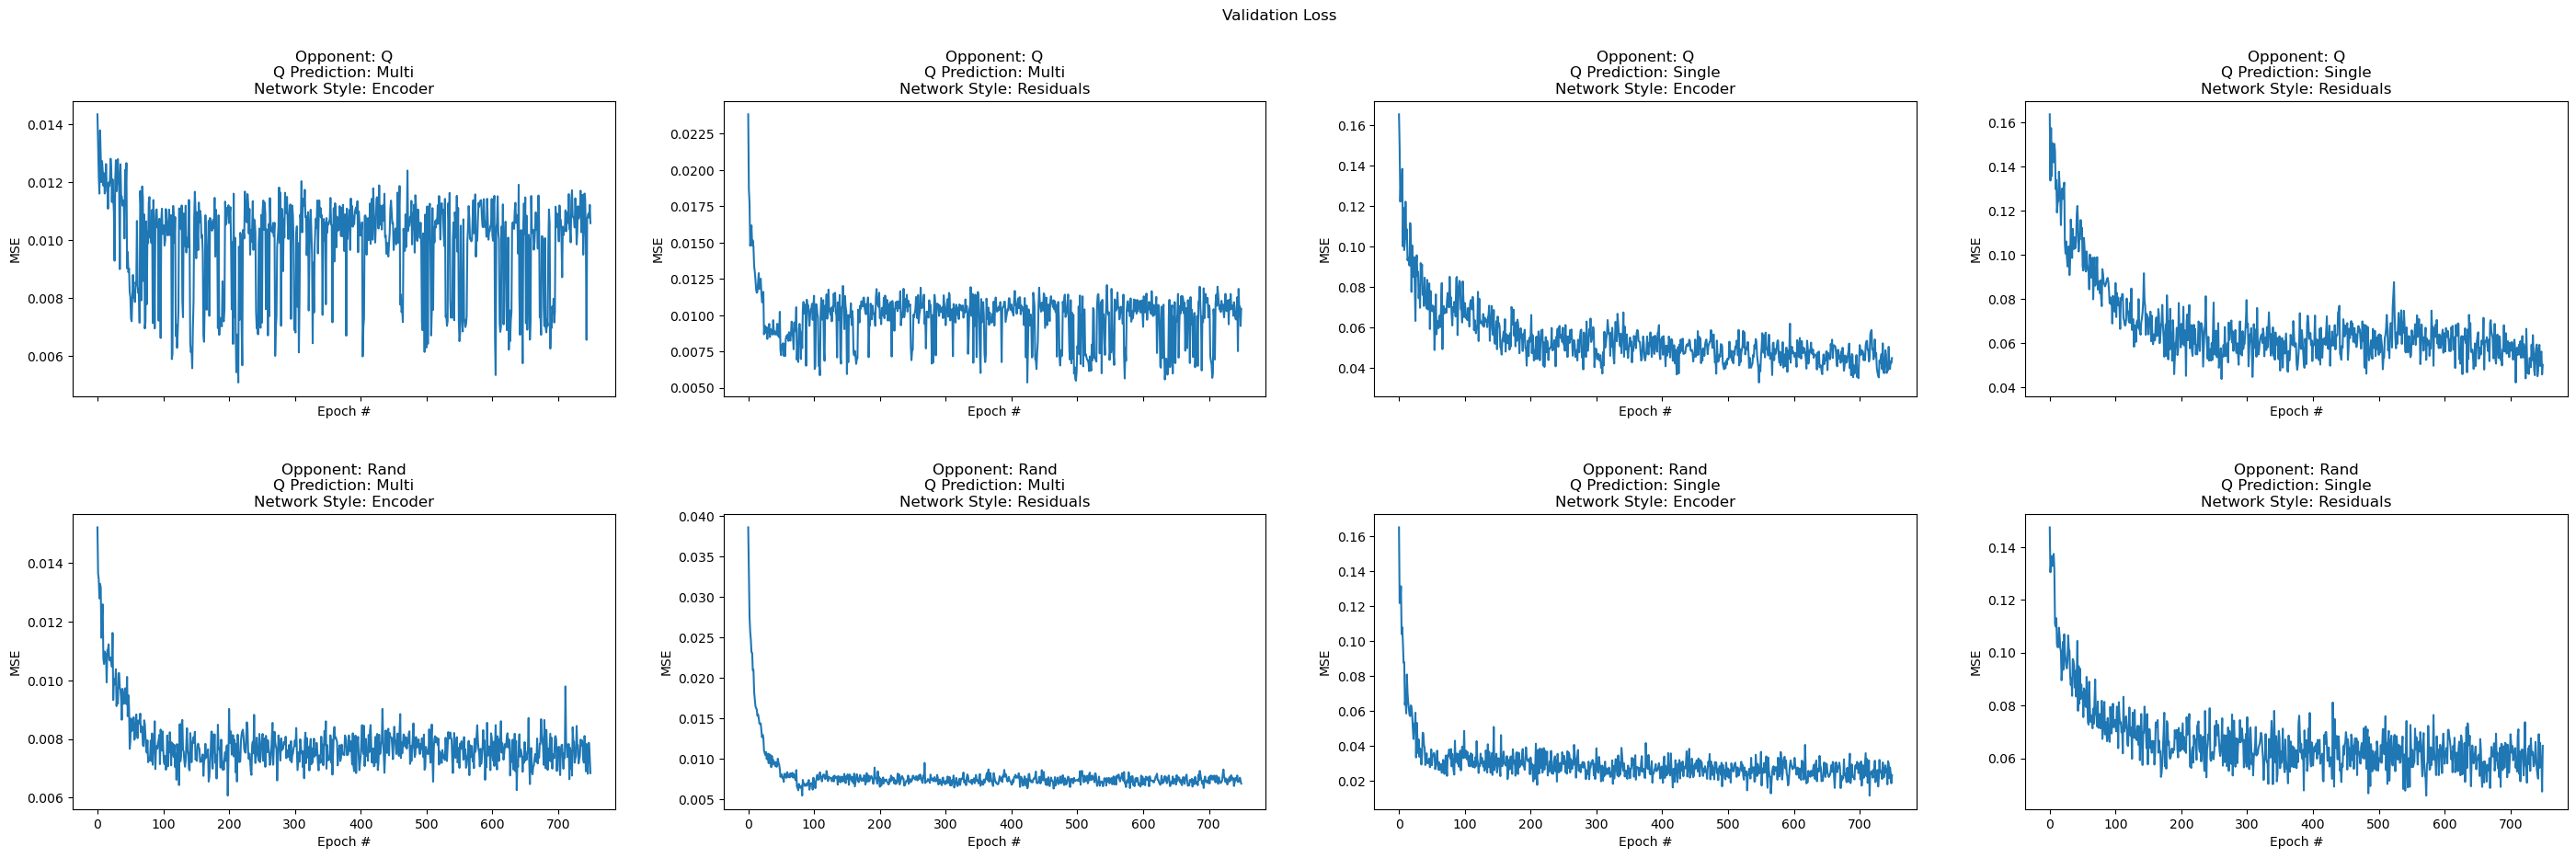

In [3]:
def plot_value(hists, key='val_loss',nrows=2,figsize=(35,10),figtitle='Validation Loss'):
    ncols = int(np.ceil(len(hists) / nrows))
    fig,axs = plt.subplots(nrows=2,ncols=ncols,figsize=figsize,sharex=True)
    for (filename,hist),ax in zip(hists,axs.flatten()):
        ttl = filename.split('_')[:-1]
        ax.plot(hist[key])
        ax.set_title(f'Opponent: {ttl[1]}\nQ Prediction: {ttl[2]}\nNetwork Style: {ttl[3]}')
        ax.set_ylabel('MSE')
        ax.set_xlabel('Epoch #')
    fig.suptitle(figtitle)
    fig.subplots_adjust(wspace=0.2,hspace=0.4)
plot_value(histories)

The above graph shows the validation loss of the agent's Q network (described by the equation above with an alpha value of 0.6). The opponent is who the agent played against, if it shows Q, then the agent played against a copy of itself, and if it shows Rand, then the agent trained against a purely random player. The Q Prediction method was described above and is the method for predicting Q values by the network. The Single style involves encoding the action with a learned embedding and multiplying that embedding with the state representation to result in a network only capable of predicting a single Q value for any given state-action pair. The multi-style has the agent only look at the state and attempt to predict the Q values of every action available which is then masked by the action. It is important to note that we need an observed $s^\prime$ to calculate the $\max\limits_{a^\prime\in A}Q^*(s^\prime,a^\prime)$ which is not possible considering the agent can only take a single action from any given state. To get around this, the agent's target value is what it would predict for the state it receives but the q value for the action that it observed itself taking is updated by $(\alpha \cdot r_{s,a}) + (1- \alpha)(\gamma \cdot \max\limits_{a^\prime\in A}Q^*(s^\prime,a^\prime))$ because we were able to observe the $s^\prime$ for the action that the agent took. This results in the model being fed a target that is identical to what it already would predict except for a single entry is changed which causes the validation loss of the multi-prediction networks to be lower in comparison to the single predictor networks and should be viewed only relative to other multi prediction style networks. The last piece is how the network is structured. The encoder structure uses a convolutional layer to encode the state before being passed to a fully connected layer to output the Q value while the D2RL style removes the convolution and instead uses residual connections from the states (and actions where applicable) to determine the Q value. Lastly, each epoch is given a different set of episodes to train and evaluate on. This means that the evaluation set is not the same in epoch 1 as it is in epoch 100, as the data is generated from the actions and states that the agent observes while it trains.

With that said, all of the networks seem to converge relatively quickly ~100 epochs( or 100,000 games). We were incorrect in assuming that the agents trained against a random player would converge sooner, but we still will need to look at some of the other evaluation criteria to determine if the policy found by playing against a random player was worse than the one found by playing against itself. The convergence alone does not tell us much other than that the q values for the next reachable state are similar to those of the current state. The Q values could still be completely off, so in the next section, we will look at a metric that will help us understand how close the Q value predictions are to the real Q values.

### Monte-Carlo Analysis

In this section, we will look at how the Q value predictions differ from the precomputed Monte Carlo simulated games. We simulate around 95,000 connect-4 games using Monte Carlo agents to get a rough ground truth for the q values for any given action. The hypothesis is that our agent's predictions for q values should be correlated to what the Monte Carlo agents found. The Monte Carlo agents simulated 500 games per action of random players and computed the rates for each action. We will then coalesce these wines via the following equation $W_a \cdot 1 + L_a \cdot -1$ where $W_a$ denotes the win rate expressed as a percentage for the red player and $L_a$ denotes the loss rate for the red player for any given action on any given board.

Lets start with loading up the different agents that we trained earlier.

In [4]:
Q_Multi_Residuals = MultiPredictionQPlayer(player_symbol=1,name='Q_Multi_Residuals')
Q_Multi_Residuals.loadPolicy('QNetworks/Q_Q_Multi_Residuals')

Q_Multi_Encoder = MultiPredictionQPlayer(player_symbol=1,name = 'Q_Multi_Encoder')
Q_Multi_Encoder.loadPolicy('QNetworks/Q_Q_Multi_Encoder')

Q_Single_Residuals = SinglePredictionQPlayer(player_symbol=1,name = 'Q_Single_Residuals')
Q_Single_Residuals.loadPolicy('QNetworks/Q_Q_Single_Residuals')

Q_Single_Encoder = SinglePredictionQPlayer(player_symbol=1,name = 'Q_Single_Encoder')
Q_Single_Encoder.loadPolicy('QNetworks/Q_Q_Single_Encoder')

Rand_Multi_Residuals = MultiPredictionQPlayer(player_symbol=1,name = 'Rand_Multi_Residuals')
Rand_Multi_Residuals.loadPolicy('QNetworks/Q_Rand_Multi_Residuals')

Rand_Multi_Encoder = MultiPredictionQPlayer(player_symbol=1,name = 'Rand_Multi_Encoder')
Rand_Multi_Encoder.loadPolicy('QNetworks/Q_Rand_Multi_Encoder')

Rand_Single_Residuals = SinglePredictionQPlayer(player_symbol=1, name = 'Rand_Single_Residuals')
Rand_Single_Residuals.loadPolicy('QNetworks/Q_Rand_Single_Residuals')

Rand_Single_Encoder = SinglePredictionQPlayer(player_symbol=1,name = 'Rand_Single_Encoder')
Rand_Single_Encoder.loadPolicy('QNetworks/Q_Rand_Single_Encoder')

agents = [
    Q_Multi_Residuals,
    Q_Multi_Encoder,
    Q_Single_Residuals,
    Q_Single_Encoder,
    Rand_Multi_Residuals,
    Rand_Multi_Encoder,
    Rand_Single_Residuals,
    Rand_Single_Encoder
]


for agent in agents: # Tell the agents the shape of the boards that they will be using and set epsilon to 0
    agent.num_rows = 6
    agent.num_cols = 7
    agent.epsilon = 0

Q_Multi_Residuals Loaded Q and Q Prime networks from file QNetworks/Q_Q_Multi_Residuals
Q_Multi_Encoder Loaded Q and Q Prime networks from file QNetworks/Q_Q_Multi_Encoder
Q_Single_Residuals Loaded Q and Q Prime networks from file QNetworks/Q_Q_Single_Residuals
Q_Single_Encoder Loaded Q and Q Prime networks from file QNetworks/Q_Q_Single_Encoder
Rand_Multi_Residuals Loaded Q and Q Prime networks from file QNetworks/Q_Rand_Multi_Residuals
Rand_Multi_Encoder Loaded Q and Q Prime networks from file QNetworks/Q_Rand_Multi_Encoder
Rand_Single_Residuals Loaded Q and Q Prime networks from file QNetworks/Q_Rand_Single_Residuals
Rand_Single_Encoder Loaded Q and Q Prime networks from file QNetworks/Q_Rand_Single_Encoder


Lets take a look at some example boards and what the data looks like for a monte carlo agent and what our agents predict

In [5]:
EXAMPLE_BOARDS_PTH = 'Example_Boards/boards.json'

with open(EXAMPLE_BOARDS_PTH, 'r') as fp:
    example_boards = json.load(fp)

len(example_boards.keys()) # 95096 boards

95096

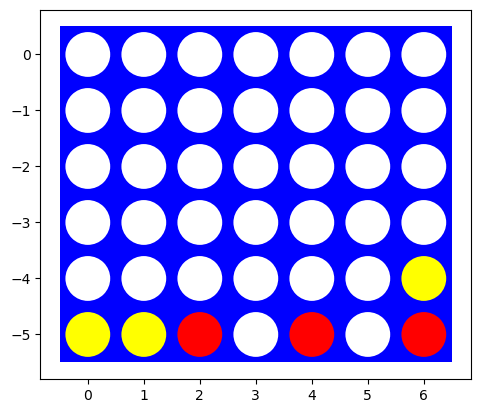

{'0': {'-1': 0.428, '0': 0.0, '1': 0.572}, '1': {'-1': 0.368, '0': 0.002, '1': 0.63}, '2': {'-1': 0.344, '0': 0.002, '1': 0.654}, '3': {'-1': 0.326, '0': 0.0, '1': 0.674}, '4': {'-1': 0.36, '0': 0.002, '1': 0.638}, '5': {'-1': 0.302, '0': 0.002, '1': 0.696}, '6': {'-1': 0.414, '0': 0.008, '1': 0.578}}


In [6]:
visualize(example_boards['665']['board'])
print(example_boards['665']['targets'])

In [7]:
for agent in agents:
    print(f'{agent.name}: {list(agent.show_q_function(np.array(example_boards["665"]["board"])))} -> {agent.choose_action(valid_actions=[0,1,2,3,4,5,6],board=np.array(example_boards["665"]["board"]))}')

Q_Multi_Residuals: [0.04702494, 0.040642537, 0.045736123, 0.036452487, 0.05584736, 0.03757701, 0.03432511] -> 4
Q_Multi_Encoder: [0.04180514, 0.037888203, 0.034792475, 0.037590366, 0.04057266, 0.033389527, 0.03607119] -> 0
Q_Single_Residuals: [0.08220566, 0.23049992, 0.34329352, 0.48228598, 0.4883125, 0.468668, 0.44191447] -> 4
Q_Single_Encoder: [0.24309766, 0.28575304, 0.29328227, 0.456665, 0.32566422, 0.4491619, 0.26940084] -> 3
Rand_Multi_Residuals: [0.13018823, 0.1331004, 0.13505563, 0.13202202, 0.1341797, 0.12577711, 0.13208766] -> 2
Rand_Multi_Encoder: [0.10906974, 0.11858619, 0.114665866, 0.12907007, 0.11380824, 0.11751991, 0.11991448] -> 3
Rand_Single_Residuals: [0.20913832, 0.23110516, 0.2654205, 0.261004, 0.2502924, 0.2417392, 0.23430663] -> 2
Rand_Single_Encoder: [0.3634847, 0.46513972, 0.50491005, 0.6893142, 0.5029305, 0.6630844, 0.41563675] -> 3


As we can see above, the monte carlo agents only stored the winrates of the different actions for the two players but the Q agents are predicting a single Q value for each action, so we now need to convert the monte carlo output to one that can be fairly compared to the Q agent outputs.

In [8]:
agent_predictions = {agent.name:[] for agent in agents}
monte_carlo_predictions = []

for board_data in tqdm(example_boards.values()):
    board = np.array(board_data['board'])
    preds = board_data['targets']
    new_preds = []
    for p in preds.values():
        new_preds.append(p['-1'] * -1 + p['1'])
    monte_carlo_predictions.append(new_preds)
    for agent in agents:
        agent_predictions[agent.name].append( list(agent.show_q_function(board)))
    

  0%|          | 0/95096 [00:00<?, ?it/s]

In [9]:
results = []
for k,v in tqdm(agent_predictions.items(),desc='Agents'):
    # print(f'Name: {k}\n\tCorrelation: {corr}\n\tP Value: {pval}')
    
    for i,(agent_preds,monte_preds) in tqdm(enumerate(zip(v,monte_carlo_predictions)),desc=f'{k}',total=len(monte_carlo_predictions)):
        corr, pval = pearsonr(agent_preds,monte_preds)
        # if not corr or np.isnan(corr):
        #     print(i)
        #     break
        same_top_action = 0
        if np.argmax(agent_preds) == np.argmax(monte_preds):
            same_top_action = 1
        top_3_agent = [ i[1] for i in sorted(zip(agent_preds,[i for i in range(len(agent_preds))]),reverse=True)[:3] ] # get top 3 agent prediciton actions 
        top_3_monte = [ i[1] for i in sorted(zip(monte_preds,[i for i in range(len(monte_preds))]),reverse=True)[:3] ] # Get top 3 monte prediction actions
        num_top_3 = 0
        for i in top_3_agent:
            if i in top_3_monte:
                num_top_3 += 1
        # top_3_monte = sorted(monte_preds,reverse=True)[:3]
        
        results.append({'Name':k,'Correlation':corr,'P Value':pval,'Board #':i,'SameAction':same_top_action,'InTop3':num_top_3})
    # break
        
results = pd.DataFrame(results)
results.sort_values(by='Correlation',ascending=False)

Agents:   0%|          | 0/8 [00:00<?, ?it/s]

Q_Multi_Residuals:   0%|          | 0/95096 [00:00<?, ?it/s]

/home/alexshock/miniconda3/envs/tf_2/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Q_Multi_Encoder:   0%|          | 0/95096 [00:00<?, ?it/s]

Q_Single_Residuals:   0%|          | 0/95096 [00:00<?, ?it/s]

Q_Single_Encoder:   0%|          | 0/95096 [00:00<?, ?it/s]

Rand_Multi_Residuals:   0%|          | 0/95096 [00:00<?, ?it/s]

Rand_Multi_Encoder:   0%|          | 0/95096 [00:00<?, ?it/s]

Rand_Single_Residuals:   0%|          | 0/95096 [00:00<?, ?it/s]

Rand_Single_Encoder:   0%|          | 0/95096 [00:00<?, ?it/s]

,Name,Correlation,P Value,Board #,SameAction,InTop3
379851,Q_Single_Encoder,0.999746,1.975082e-09,1,0,2
690780,Rand_Single_Encoder,0.999689,3.267828e-09,4,1,3
304570,Q_Single_Encoder,0.999495,1.099070e-08,1,0,3
317016,Q_Single_Encoder,0.999460,1.302933e-08,0,1,3
310519,Q_Single_Encoder,0.999456,1.327045e-08,2,1,3
...,...,...,...,...,...,...
742120,Rand_Single_Encoder,NaN,NaN,5,0,1
757003,Rand_Single_Encoder,NaN,NaN,1,0,1
759347,Rand_Single_Encoder,NaN,NaN,1,0,1
760500,Rand_Single_Encoder,NaN,NaN,0,0,1


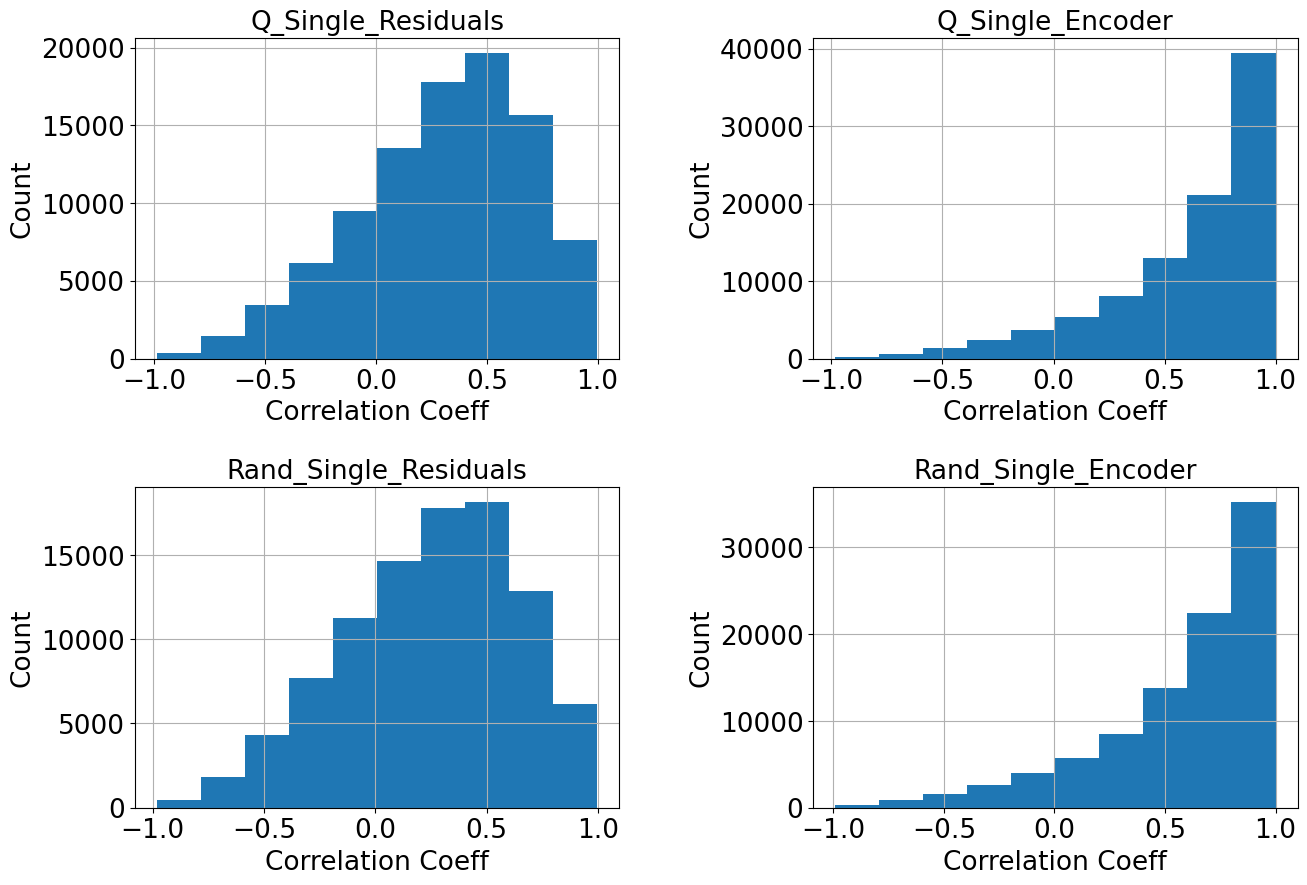

In [36]:
results =  results.dropna()


fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(15,10))
plt.rc('xtick',labelsize=19)
plt.rc('ytick',labelsize=19)
plt.rc('axes',titlesize=19)
plt.rc('axes',labelsize=19)
plt.subplots_adjust(hspace=0.4,wspace=0.4)
for alg,ax in zip([a for a in agent_predictions.keys() if "Single" in a],axs.flatten()):

    results[results['Name'] == alg]['Correlation'].hist(ax=ax)
    ax.set_title(alg)
    ax.set_ylabel('Count')
    ax.set_xlabel('Correlation Coeff')

In [11]:
results[['Name','SameAction']].groupby('Name').mean()

,SameAction
Name,
Q_Multi_Encoder,0.113684
Q_Multi_Residuals,0.147190
Q_Single_Encoder,0.607311
Q_Single_Residuals,0.341315
Rand_Multi_Encoder,0.266784
Rand_Multi_Residuals,0.180128
Rand_Single_Encoder,0.583796
Rand_Single_Residuals,0.280666


In [12]:
results.groupby('Name')['InTop3'].value_counts().sort_index()

Name                   InTop3
Q_Multi_Encoder        0         15058
                       1         52578
                       2         25800
                       3          1652
Q_Multi_Residuals      0         11311
                       1         50117
                       2         31512
                       3          2148
Q_Single_Encoder       0          1607
                       1         23426
                       2         53733
                       3         16322
Q_Single_Residuals     0          4211
                       1         36749
                       2         46942
                       3          7186
Rand_Multi_Encoder     0          8828
                       1         49793
                       2         34001
                       3          2466
Rand_Multi_Residuals   0          8413
                       1         46811
                       2         36742
                       3          3122
Rand_Single_Encoder    0          

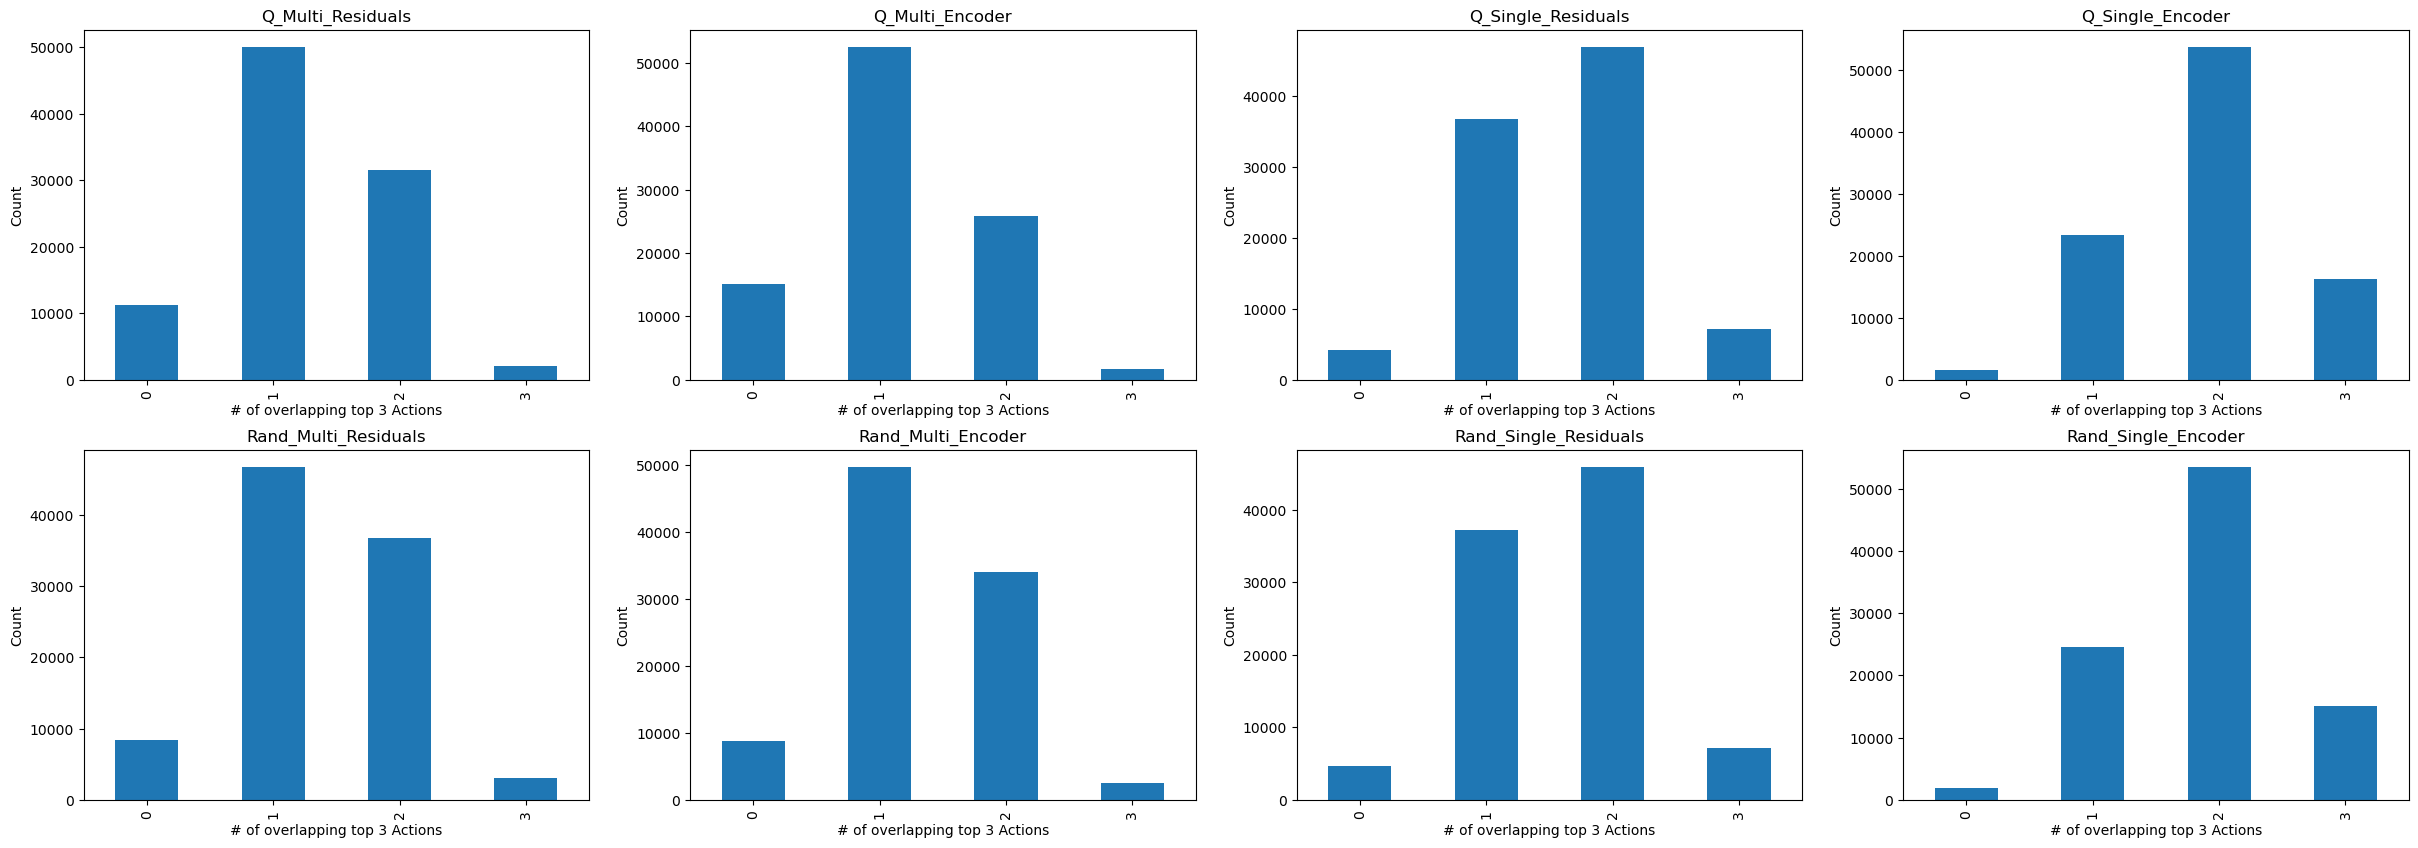

In [13]:
fig, axs = plt.subplots(nrows=2,ncols=4,figsize=(30,10))
for alg,ax in zip(agent_predictions.keys(),axs.flatten()):
    results[results['Name'] == alg]['InTop3'].value_counts().sort_index().plot.bar(ax=ax)
    ax.set_title(alg)
    ax.set_ylabel('Count')
    ax.set_xlabel('# of overlapping top 3 Actions')

Based on the above table, it appears that the Single encoder architecture was the strongest architecture when it comes to predicting how a Monte Carlo agent would perform. It also appears that the multiple-output predictors performed worse than the single-output ones which is not what we initially expected. It is important to note that the above table is only a correlation between the Q values that the agents output and the Monte Carlo evaluation results. Looking at just this evaluation metric would lead us to conclude that the single-value predictor networks significantly outperform the multi-value predictor networks for the game Connect-4. Looking at the standard deviation, min, and max values of q values being outputted by each of the different agents also shows that the multi-predictor agents had a much lower standard deviation across the values that they are predicting. They were also incapable of outputting a Q value of 1 which shows that they were unable to learn desirable states to be in. The multi-predictor agents are unable to discern what action they should take and just make nearly random actions which is undesirable for agent performance. We will look further into the agent performance in the next section where we play the agents against varying levels of opponents to determine their skill at learning the complex strategies of Connect-4.

### Tournament Style Evaluation

To be implemented for the final submission

In [14]:
def simulate_games(agent,opp,ngames=50):
    total_score = 0.0
    for i in tqdm(range(ngames),desc=f'{agent.name} vs {opp.__class__}'):
        b = Board(agent,opp)
        res = b.play_agents(verbose=0)
        if res == 1:
            total_score += 1
        elif res == 0 or res is None:
            total_score += 0.5
        elif res == -1:
            total_score = 0
        else:
            raise RuntimeError(f"Recieved unknown output from board: {res}")
    return total_score/ngames


In [15]:
opps = [
    ('RandomPlayer',RandomPlayer(player_symbol=-1)),
    ('GreedyPlayer',GreedyPlayer(player_symbol=-1)),
    ('Monte_25',MonteCarloPlayer(player_symbol=-1,num_sims=25)),
    ('Monte_50',MonteCarloPlayer(player_symbol=-1,num_sims=50)),
    ('Monte_75',MonteCarloPlayer(player_symbol=-1,num_sims=75)),
    ('Monte_100',MonteCarloPlayer(player_symbol=-1,num_sims=100)),
]



In [16]:
# agent_scores = {agent.name:[] for agent in agents}


score_results = []


for agent in tqdm(agents,desc='Agents'):
    # print(f'Name: {k}\n\tCorrelation: {corr}\n\tP Value: {pval}')
    
    for opp_name,opp in opps:
        res = simulate_games(agent,opp)
        
        score_results.append({'Name':agent.name,'Score':res,'Opp':opp_name})
score_results = pd.DataFrame(score_results)
score_results.sort_values(by='Score',ascending=False)

Agents:   0%|          | 0/8 [00:00<?, ?it/s]

Q_Multi_Residuals vs <class 'deepq.RandomPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Q_Multi_Residuals vs <class 'deepq.GreedyPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Q_Multi_Residuals vs <class 'deepq.MonteCarloPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Q_Multi_Residuals vs <class 'deepq.MonteCarloPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Q_Multi_Residuals vs <class 'deepq.MonteCarloPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Q_Multi_Residuals vs <class 'deepq.MonteCarloPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Q_Multi_Encoder vs <class 'deepq.RandomPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Q_Multi_Encoder vs <class 'deepq.GreedyPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Q_Multi_Encoder vs <class 'deepq.MonteCarloPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Q_Multi_Encoder vs <class 'deepq.MonteCarloPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Q_Multi_Encoder vs <class 'deepq.MonteCarloPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Q_Multi_Encoder vs <class 'deepq.MonteCarloPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Q_Single_Residuals vs <class 'deepq.RandomPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Q_Single_Residuals vs <class 'deepq.GreedyPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Q_Single_Residuals vs <class 'deepq.MonteCarloPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Q_Single_Residuals vs <class 'deepq.MonteCarloPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Q_Single_Residuals vs <class 'deepq.MonteCarloPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Q_Single_Residuals vs <class 'deepq.MonteCarloPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Q_Single_Encoder vs <class 'deepq.RandomPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Q_Single_Encoder vs <class 'deepq.GreedyPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Q_Single_Encoder vs <class 'deepq.MonteCarloPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Q_Single_Encoder vs <class 'deepq.MonteCarloPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Q_Single_Encoder vs <class 'deepq.MonteCarloPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Q_Single_Encoder vs <class 'deepq.MonteCarloPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Rand_Multi_Residuals vs <class 'deepq.RandomPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Rand_Multi_Residuals vs <class 'deepq.GreedyPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Rand_Multi_Residuals vs <class 'deepq.MonteCarloPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Rand_Multi_Residuals vs <class 'deepq.MonteCarloPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Rand_Multi_Residuals vs <class 'deepq.MonteCarloPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Rand_Multi_Residuals vs <class 'deepq.MonteCarloPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Rand_Multi_Encoder vs <class 'deepq.RandomPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Rand_Multi_Encoder vs <class 'deepq.GreedyPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Rand_Multi_Encoder vs <class 'deepq.MonteCarloPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Rand_Multi_Encoder vs <class 'deepq.MonteCarloPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Rand_Multi_Encoder vs <class 'deepq.MonteCarloPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Rand_Multi_Encoder vs <class 'deepq.MonteCarloPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Rand_Single_Residuals vs <class 'deepq.RandomPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Rand_Single_Residuals vs <class 'deepq.GreedyPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Rand_Single_Residuals vs <class 'deepq.MonteCarloPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Rand_Single_Residuals vs <class 'deepq.MonteCarloPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Rand_Single_Residuals vs <class 'deepq.MonteCarloPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Rand_Single_Residuals vs <class 'deepq.MonteCarloPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Rand_Single_Encoder vs <class 'deepq.RandomPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Rand_Single_Encoder vs <class 'deepq.GreedyPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Rand_Single_Encoder vs <class 'deepq.MonteCarloPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Rand_Single_Encoder vs <class 'deepq.MonteCarloPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Rand_Single_Encoder vs <class 'deepq.MonteCarloPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

Rand_Single_Encoder vs <class 'deepq.MonteCarloPlayer'>:   0%|          | 0/50 [00:00<?, ?it/s]

,Name,Score,Opp
42,Rand_Single_Encoder,1.00,RandomPlayer
12,Q_Single_Residuals,1.00,RandomPlayer
18,Q_Single_Encoder,1.00,RandomPlayer
36,Rand_Single_Residuals,0.68,RandomPlayer
44,Rand_Single_Encoder,0.46,Monte_25
6,Q_Multi_Encoder,0.34,RandomPlayer
19,Q_Single_Encoder,0.28,GreedyPlayer
24,Rand_Multi_Residuals,0.16,RandomPlayer
30,Rand_Multi_Encoder,0.08,RandomPlayer
21,Q_Single_Encoder,0.04,Monte_50


In [19]:
score_results.sort_values(by=['Name','Opp'],ascending=False)

,Name,Score,Opp
36,Rand_Single_Residuals,0.68,RandomPlayer
40,Rand_Single_Residuals,0.00,Monte_75
39,Rand_Single_Residuals,0.00,Monte_50
38,Rand_Single_Residuals,0.00,Monte_25
41,Rand_Single_Residuals,0.00,Monte_100
37,Rand_Single_Residuals,0.00,GreedyPlayer
42,Rand_Single_Encoder,1.00,RandomPlayer
46,Rand_Single_Encoder,0.00,Monte_75
45,Rand_Single_Encoder,0.00,Monte_50
44,Rand_Single_Encoder,0.46,Monte_25
